# 🏦 Actividad Clase 03: Regresión Logística
# Predicción de Churn Bancario - FinanceGuard

---

## 🎯 ¿Qué vamos a hacer?

**FinanceGuard** es un banco digital con un problema: el **20% de sus clientes se van cada año** (esto se llama "churn").

Nuestra misión: **Predecir qué clientes se van a ir** para poder retenerlos a tiempo.

### 🤔 ¿Qué es el Churn?

**Churn** = Cuando un cliente deja de usar el servicio del banco.

**¿Por qué es importante?**
- Conseguir un cliente nuevo cuesta **5-7 veces más** que mantener uno actual
- Un cliente que se queda muchos años genera mucho más dinero
- Si muchos clientes se van, el banco pierde dinero

**Ejemplo de la vida real:**
Imagina que tienes una tienda de helados. Si cada semana pierdes 20 clientes y solo consigues 10 nuevos, ¡te estás quedando sin clientes! Es más fácil y barato hacer que tus clientes actuales estén felices que salir a buscar nuevos todo el tiempo.

---

## 📚 ¿Qué es la Regresión Logística?

### Concepto Simple

La regresión logística es como un **detector de riesgo** que nos dice:
- ¿Qué probabilidad hay de que este cliente se vaya?
- La respuesta es un número entre 0 y 1 (o entre 0% y 100%)

**Ejemplo:**
- Cliente A: 80% de probabilidad de irse → ¡ALERTA ROJA!
- Cliente B: 20% de probabilidad de irse → Está bien

### La Función Sigmoide 📈

Es la "fórmula mágica" que transforma cualquier número en una probabilidad (entre 0 y 1).

**Fórmula matemática:**

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**¿Qué significa cada parte?**
- $\sigma$ (sigma): Es la probabilidad final (entre 0 y 1)
- $z$: Es una combinación de las características del cliente (edad, saldo, etc.)
- $e$: Es el número de Euler (≈ 2.718), una constante matemática

**Ejemplo numérico:**
- Si $z = 0$ → $\sigma(0) = 0.5$ (50% de probabilidad)
- Si $z = 2$ → $\sigma(2) = 0.88$ (88% de probabilidad)
- Si $z = -2$ → $\sigma(-2) = 0.12$ (12% de probabilidad)

### Odds y Odds Ratio 🎲

**Odds (Momios):**
Es otra forma de expresar probabilidades, muy usada en apuestas.

$$Odds = \frac{P(churn)}{1 - P(churn)}$$

**Ejemplo:**
- Si probabilidad de churn = 75% (0.75)
- Odds = 0.75 / (1 - 0.75) = 0.75 / 0.25 = 3
- **Interpretación**: "3 a 1" → Por cada 3 veces que se va, 1 vez se queda

**Odds Ratio:**
Nos dice cuánto cambian las odds cuando una variable aumenta.

$$OR = e^{coeficiente}$$

**Ejemplo:**
- Si coeficiente de "Edad" = 0.69
- OR = $e^{0.69}$ = 2.0
- **Interpretación**: Por cada año más de edad, las odds de irse se DUPLICAN

---

## 1. Importar Librerías

Estas son las herramientas que vamos a usar.

In [1]:
# Para trabajar con datos
import pandas as pd  # Tablas de datos
import numpy as np   # Operaciones matemáticas

# Para hacer gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Para preparar los datos
from sklearn.model_selection import train_test_split  # Dividir datos
from sklearn.preprocessing import StandardScaler      # Normalizar números
from sklearn.preprocessing import LabelEncoder        # Convertir categorías a números

# Para el modelo
from sklearn.linear_model import LogisticRegression   # El algoritmo principal

# Para evaluar el modelo
from sklearn.metrics import (
    confusion_matrix,      # Tabla de aciertos y errores
    classification_report,  # Reporte completo
    roc_auc_score,         # Puntuación ROC
    roc_curve              # Curva ROC
)

# Para calcular intervalos de confianza
from scipy import stats

# Ignorar advertencias para mejor visualización
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## 2. Cargar y Explorar los Datos

Vamos a cargar el dataset de 10,000 clientes del banco.

In [2]:
# Cargar el archivo CSV
df = pd.read_csv('../data/Churn_Modelling.csv')

print("📊 INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"Número de clientes: {len(df):,}")
print(f"Número de variables: {df.shape[1]}")
print(f"\nPrimeras filas:")
df.head()

📊 INFORMACIÓN DEL DATASET
Número de clientes: 10,000
Número de variables: 14

Primeras filas:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 2.1 ¿Qué significan las columnas?

**Variables Demográficas** (características de la persona):
- `Age`: Edad del cliente (en años)
- `Gender`: Género (Male = Hombre, Female = Mujer)
- `Geography`: País donde vive (France, Spain, Germany)
- `Tenure`: Cuántos años lleva en el banco (antigüedad)

**Variables Financieras** (relacionadas con dinero):
- `CreditScore`: Puntaje de crédito (300-850, más alto = mejor)
- `Balance`: Dinero en la cuenta
- `EstimatedSalary`: Salario estimado anual
- `NumOfProducts`: Cuántos productos tiene (cuenta, tarjeta, etc.)
- `HasCrCard`: ¿Tiene tarjeta de crédito? (1=Sí, 0=No)
- `IsActiveMember`: ¿Es cliente activo? (1=Sí, 0=No)

**Variable Objetivo** 🎯:
- `Exited`: ¿Se fue del banco? (1=Sí se fue, 0=No, se quedó)

**Columnas que NO vamos a usar** (son solo identificadores):
- `RowNumber`: Número de fila
- `CustomerId`: ID del cliente
- `Surname`: Apellido

In [3]:
# Ver información detallada
print("\n📋 INFORMACIÓN DETALLADA")
df.info()


📋 INFORMACIÓN DETALLADA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
# Estadísticas básicas
print("\n📈 ESTADÍSTICAS BÁSICAS")
df.describe()


📈 ESTADÍSTICAS BÁSICAS


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
# ¿Hay datos faltantes?
print("\n🔎 VERIFICACIÓN DE DATOS FALTANTES")
print("=" * 60)
print(df.isnull().sum())
print(f"\n✅ Total de valores nulos: {df.isnull().sum().sum()}")


🔎 VERIFICACIÓN DE DATOS FALTANTES
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

✅ Total de valores nulos: 0


### 2.2 Análisis de la Variable Objetivo: Churn

Lo primero que queremos saber es: **¿Cuántos clientes se fueron?**

🎯 ANÁLISIS DE CHURN

Clientes que SE QUEDARON (0): 7,963 (79.6%)
Clientes que SE FUERON (1):   2,037 (20.4%)

Tasa de churn: 20.4%


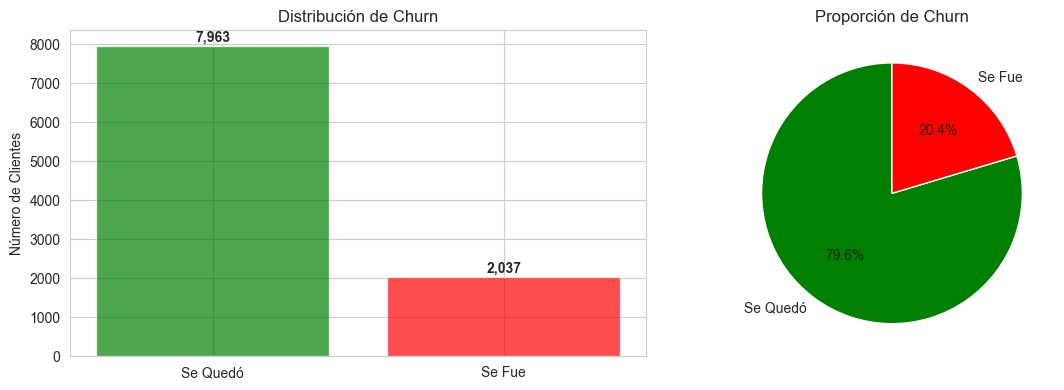


⚠️ DESBALANCEO DE CLASES
Hay 3.9 clientes que se quedan por cada 1 que se va
Esto significa que el dataset está DESBALANCEADO

💡 Implicación: El modelo tenderá a predecir 'No Churn' más frecuentemente


In [6]:
# Contar cuántos se fueron y cuántos se quedaron
churn_counts = df['Exited'].value_counts()
churn_percentages = df['Exited'].value_counts(normalize=True) * 100

print("🎯 ANÁLISIS DE CHURN")
print("=" * 60)
print(f"\nClientes que SE QUEDARON (0): {churn_counts[0]:,} ({churn_percentages[0]:.1f}%)")
print(f"Clientes que SE FUERON (1):   {churn_counts[1]:,} ({churn_percentages[1]:.1f}%)")
print(f"\nTasa de churn: {churn_percentages[1]:.1f}%")

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
axes[0].bar(['Se Quedó', 'Se Fue'], churn_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Número de Clientes')
axes[0].set_title('Distribución de Churn')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Gráfico circular
axes[1].pie(churn_counts.values, labels=['Se Quedó', 'Se Fue'],
           autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title('Proporción de Churn')

plt.tight_layout()
plt.show()

# Analizar desbalanceo
print("\n⚠️ DESBALANCEO DE CLASES")
ratio = churn_counts[0] / churn_counts[1]
print(f"Hay {ratio:.1f} clientes que se quedan por cada 1 que se va")
print(f"Esto significa que el dataset está DESBALANCEADO")
print(f"\n💡 Implicación: El modelo tenderá a predecir 'No Churn' más frecuentemente")

### 2.3 Exploración de Variables Demográficas

Veamos cómo se relacionan las características demográficas con el churn.

🌍 CHURN POR PAÍS
           sum  count      mean  churn_rate_%
Geography                                    
France     810   5014  0.161548     16.154767
Germany    814   2509  0.324432     32.443204
Spain      413   2477  0.166734     16.673395


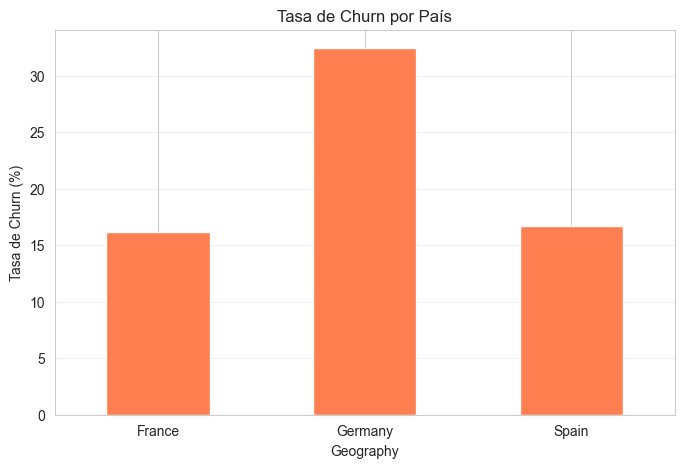


💡 Observación: ¿Qué país tiene mayor churn?


In [7]:
# Analizar Geography (País)
print("🌍 CHURN POR PAÍS")
print("=" * 60)
geography_churn = df.groupby('Geography')['Exited'].agg(['sum', 'count', 'mean'])
geography_churn['churn_rate_%'] = geography_churn['mean'] * 100
print(geography_churn)

# Graficar
plt.figure(figsize=(8, 5))
geography_churn['churn_rate_%'].plot(kind='bar', color='coral')
plt.ylabel('Tasa de Churn (%)')
plt.title('Tasa de Churn por País')
plt.xticks(rotation=0)
plt.grid(alpha=0.3, axis='y')
plt.show()

print("\n💡 Observación: ¿Qué país tiene mayor churn?")


👥 CHURN POR GÉNERO
         sum  count      mean  churn_rate_%
Gender                                     
Female  1139   4543  0.250715     25.071539
Male     898   5457  0.164559     16.455928


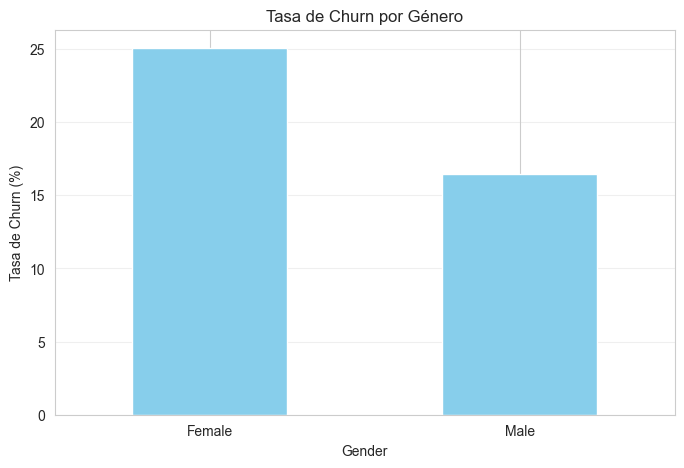


💡 Observación: ¿Hay diferencia entre hombres y mujeres?


In [8]:
# Analizar Gender (Género)
print("\n👥 CHURN POR GÉNERO")
print("=" * 60)
gender_churn = df.groupby('Gender')['Exited'].agg(['sum', 'count', 'mean'])
gender_churn['churn_rate_%'] = gender_churn['mean'] * 100
print(gender_churn)

# Graficar
plt.figure(figsize=(8, 5))
gender_churn['churn_rate_%'].plot(kind='bar', color='skyblue')
plt.ylabel('Tasa de Churn (%)')
plt.title('Tasa de Churn por Género')
plt.xticks(rotation=0)
plt.grid(alpha=0.3, axis='y')
plt.show()

print("\n💡 Observación: ¿Hay diferencia entre hombres y mujeres?")

### 2.4 Exploración de Variables Financieras

Comparemos las variables numéricas entre clientes que se fueron y los que se quedaron.

📊 EDAD: Clientes que se fueron vs que se quedaron
Edad promedio - Se Quedaron: 37.4 años
Edad promedio - Se Fueron:    44.8 años


<Figure size 1000x500 with 0 Axes>

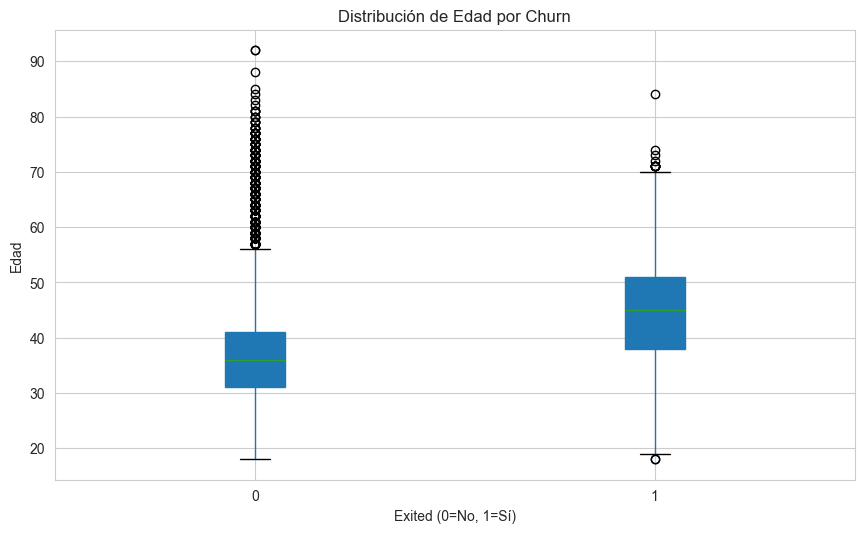


💡 ¿Los clientes mayores tienen más probabilidad de irse?


In [9]:
# Comparar Age (Edad)
print("📊 EDAD: Clientes que se fueron vs que se quedaron")
print("=" * 60)
print(f"Edad promedio - Se Quedaron: {df[df['Exited']==0]['Age'].mean():.1f} años")
print(f"Edad promedio - Se Fueron:    {df[df['Exited']==1]['Age'].mean():.1f} años")

# Graficar
plt.figure(figsize=(10, 5))
df.boxplot(column='Age', by='Exited', patch_artist=True)
plt.xlabel('Exited (0=No, 1=Sí)')
plt.ylabel('Edad')
plt.title('Distribución de Edad por Churn')
plt.suptitle('')  # Eliminar título automático
plt.show()

print("\n💡 ¿Los clientes mayores tienen más probabilidad de irse?")


💰 BALANCE: Clientes que se fueron vs que se quedaron
Balance promedio - Se Quedaron: $72,745.30
Balance promedio - Se Fueron:    $91,108.54


<Figure size 1000x500 with 0 Axes>

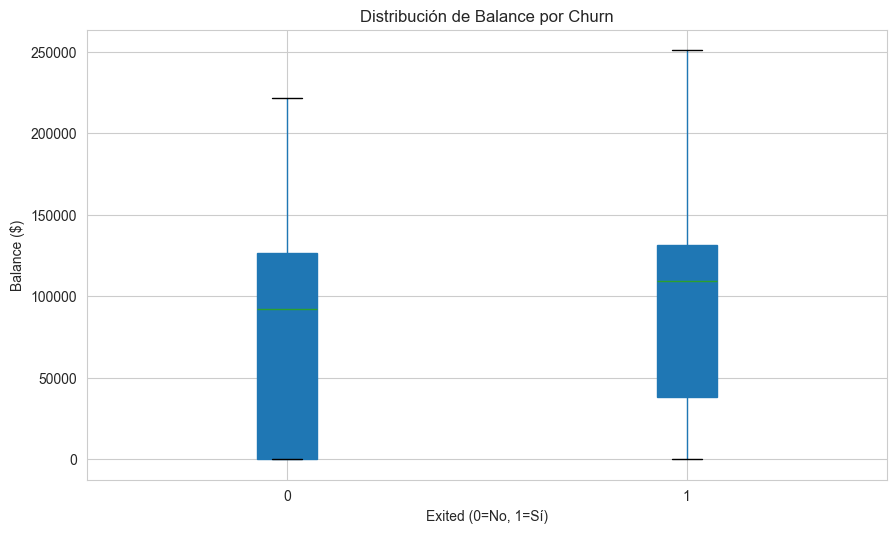


💡 ¿Los clientes con más dinero se van más?


In [10]:
# Comparar Balance (Saldo en cuenta)
print("\n💰 BALANCE: Clientes que se fueron vs que se quedaron")
print("=" * 60)
print(f"Balance promedio - Se Quedaron: ${df[df['Exited']==0]['Balance'].mean():,.2f}")
print(f"Balance promedio - Se Fueron:    ${df[df['Exited']==1]['Balance'].mean():,.2f}")

# Graficar
plt.figure(figsize=(10, 5))
df.boxplot(column='Balance', by='Exited', patch_artist=True)
plt.xlabel('Exited (0=No, 1=Sí)')
plt.ylabel('Balance ($)')
plt.title('Distribución de Balance por Churn')
plt.suptitle('')
plt.show()

print("\n💡 ¿Los clientes con más dinero se van más?")

### 2.5 Matriz de Correlación

Veamos qué variables están más relacionadas con el churn.

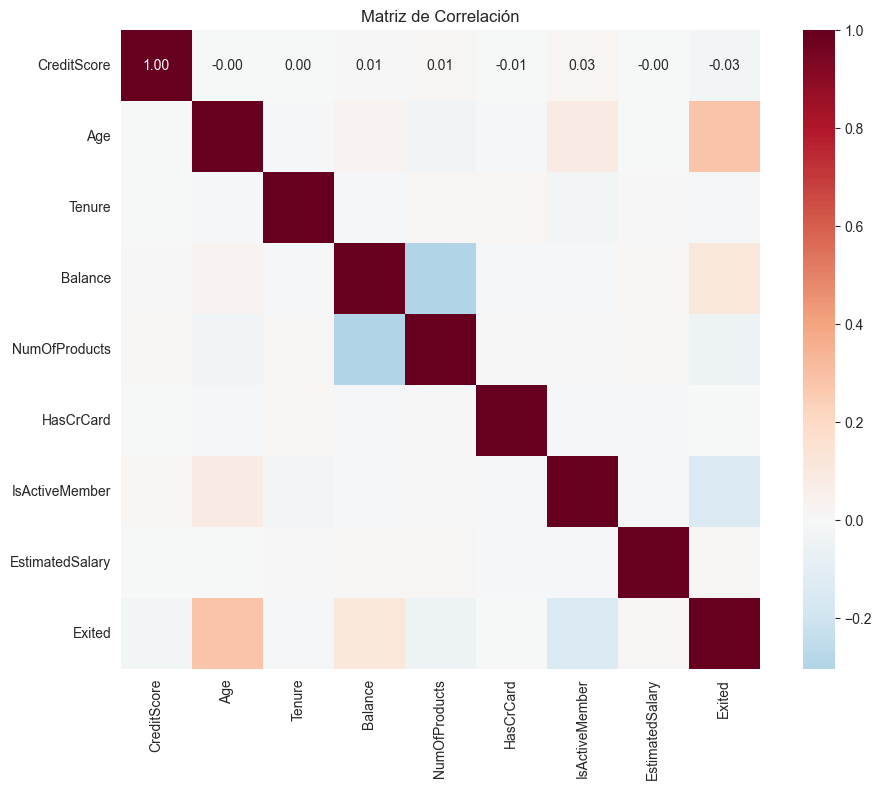


🔗 CORRELACIÓN CON CHURN (Exited)
Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64

💡 Interpretación:
   • Valores positivos (+): A mayor valor, mayor churn
   • Valores negativos (-): A mayor valor, menor churn
   • Cercano a 0: Poca relación

⚠️ MULTICOLINEALIDAD (correlación alta entre predictores)
Buscando correlaciones > 0.7...
   ✅ No se detectó multicolinealidad significativa


In [11]:
# Seleccionar variables numéricas
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
corr_matrix = df[numeric_cols].corr()

# Visualizar
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

# Mostrar correlaciones con Churn
print("\n🔗 CORRELACIÓN CON CHURN (Exited)")
print("=" * 60)
churn_corr = corr_matrix['Exited'].sort_values(ascending=False)
print(churn_corr)

print("\n💡 Interpretación:")
print("   • Valores positivos (+): A mayor valor, mayor churn")
print("   • Valores negativos (-): A mayor valor, menor churn")
print("   • Cercano a 0: Poca relación")

# Verificar multicolinealidad
print("\n⚠️ MULTICOLINEALIDAD (correlación alta entre predictores)")
print("Buscando correlaciones > 0.7...")
high_corr_found = False
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7 and corr_matrix.columns[i] != 'Exited' and corr_matrix.columns[j] != 'Exited':
            print(f"   {corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")
            high_corr_found = True
if not high_corr_found:
    print("   ✅ No se detectó multicolinealidad significativa")

## 3. Preparación de Datos

Antes de entrenar el modelo, debemos preparar los datos.

### 3.1 Eliminar Columnas Innecesarias

In [12]:
# Crear copia para no modificar el original
df_model = df.copy()

# Eliminar columnas que son solo identificadores
df_model = df_model.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

print("🗑️ COLUMNAS ELIMINADAS")
print("   • RowNumber: Solo es el número de fila")
print("   • CustomerId: Solo es un ID único")
print("   • Surname: El apellido no aporta información")
print(f"\n✅ Ahora tenemos {df_model.shape[1]} columnas")

🗑️ COLUMNAS ELIMINADAS
   • RowNumber: Solo es el número de fila
   • CustomerId: Solo es un ID único
   • Surname: El apellido no aporta información

✅ Ahora tenemos 11 columnas


### 3.2 Encoding de Variables Categóricas

Los algoritmos solo entienden números. Debemos convertir:
- **Gender** (Male/Female) → números
- **Geography** (France/Spain/Germany) → números

**Label Encoding**: Para variables con 2 categorías (Gender)
- Male → 1
- Female → 0

**One-Hot Encoding**: Para variables con 3+ categorías (Geography)
- Crea una columna por cada país
- Geography_Germany: 1 si es Germany, 0 si no
- Geography_Spain: 1 si es Spain, 0 si no
- (France queda como referencia cuando ambas son 0)

In [13]:
# Label Encoding para Gender
print("🔢 LABEL ENCODING: Gender")
print("=" * 60)
print(f"Valores originales: {df_model['Gender'].unique()}")

le_gender = LabelEncoder()
df_model['Gender'] = le_gender.fit_transform(df_model['Gender'])

print(f"Valores codificados: {df_model['Gender'].unique()}")
print(f"Mapeo: Male={le_gender.transform(['Male'])[0]}, Female={le_gender.transform(['Female'])[0]}")

🔢 LABEL ENCODING: Gender
Valores originales: ['Female' 'Male']
Valores codificados: [0 1]
Mapeo: Male=1, Female=0


In [14]:
# One-Hot Encoding para Geography
print("\n🌍 ONE-HOT ENCODING: Geography")
print("=" * 60)
print(f"Valores originales: {df_model['Geography'].unique()}")

# Crear columnas dummy (drop_first=True evita redundancia)
geography_dummies = pd.get_dummies(df_model['Geography'], prefix='Geography', drop_first=True)
print(f"\nColumnas creadas: {list(geography_dummies.columns)}")
print("\n💡 ¿Por qué drop_first=True?")
print("   Si Germany=0 y Spain=0, automáticamente sabemos que es France")
print("   Esto evita la 'trampa de variables dummy' (multicolinealidad perfecta)")

# Agregar al dataframe y eliminar original
df_model = pd.concat([df_model, geography_dummies], axis=1)
df_model = df_model.drop('Geography', axis=1)

print(f"\n✅ Ahora tenemos {df_model.shape[1]} columnas totales")
df_model.head()


🌍 ONE-HOT ENCODING: Geography
Valores originales: ['France' 'Spain' 'Germany']

Columnas creadas: ['Geography_Germany', 'Geography_Spain']

💡 ¿Por qué drop_first=True?
   Si Germany=0 y Spain=0, automáticamente sabemos que es France
   Esto evita la 'trampa de variables dummy' (multicolinealidad perfecta)

✅ Ahora tenemos 12 columnas totales


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


### 3.3 Separar Features (X) y Target (y)

In [15]:
# X = Variables independientes (features) - todo menos Exited
X = df_model.drop('Exited', axis=1)

# y = Variable dependiente (target) - solo Exited
y = df_model['Exited']

print("📊 SEPARACIÓN DE DATOS")
print("=" * 60)
print(f"Features (X): {X.shape[1]} columnas")
print(f"Columnas: {list(X.columns)}")
print(f"\nTarget (y): {y.name}")
print(f"Valores: 0 (No Churn) y 1 (Churn)")

📊 SEPARACIÓN DE DATOS
Features (X): 11 columnas
Columnas: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']

Target (y): Exited
Valores: 0 (No Churn) y 1 (Churn)


### 3.4 Split Train/Test (80-20)

**¿Por qué dividir los datos?**
- **Train (80%)**: Para que el modelo "aprenda"
- **Test (20%)**: Para evaluar si realmente aprendió (datos que nunca vio)

**Analogía**: Es como estudiar para un examen con ejercicios de práctica (train) y luego hacer el examen real con ejercicios nuevos (test).

In [16]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% para test
    random_state=42,     # Para reproducibilidad
    stratify=y           # Mantener proporción de churn en ambos conjuntos
)

print("🔀 DIVISIÓN DE DATOS (80-20)")
print("=" * 60)
print(f"\nTrain set: {len(X_train):,} clientes")
print(f"Test set:  {len(X_test):,} clientes")

print(f"\nProporción de churn en Train: {y_train.mean()*100:.1f}%")
print(f"Proporción de churn en Test:  {y_test.mean()*100:.1f}%")
print("\n✅ Estratificación exitosa: Misma proporción en ambos conjuntos")

🔀 DIVISIÓN DE DATOS (80-20)

Train set: 8,000 clientes
Test set:  2,000 clientes

Proporción de churn en Train: 20.4%
Proporción de churn en Test:  20.3%

✅ Estratificación exitosa: Misma proporción en ambos conjuntos


### 3.5 Escalamiento de Variables Numéricas (StandardScaler)

**¿Por qué escalar?**

Las variables tienen escalas muy diferentes:
- Age: 18-92
- Balance: 0-250,000
- NumOfProducts: 1-4

Esto confunde al modelo. **StandardScaler** normaliza todo para que tengan:
- Media = 0
- Desviación estándar = 1

**Fórmula:**
$$z = \frac{x - \mu}{\sigma}$$

Donde:
- $x$ (se pronuncia "equis"): Valor original
- $\mu$ (se pronuncia "mu"): Media
- $\sigma$ (se pronuncia "sigma"): Desviación estándar
- $z$ (se pronuncia "zeta"): Valor escalado

**Ejemplo:**
- Si Age = 45, media ($\mu$) = 38, std ($\sigma$) = 10
- z (zeta) = (45 - 38) / 10 = 0.7
- Interpretación: Esta edad está 0.7 desviaciones estándar por encima de la media

In [17]:
# Crear el scaler
scaler = StandardScaler()

# ⚠️ MUY IMPORTANTE: Solo "fit" con train, nunca con test
# Esto previene "data leakage" (que el modelo vea información del test)
scaler.fit(X_train)

# Transformar ambos conjuntos
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("📏 ESCALAMIENTO DE VARIABLES")
print("=" * 60)
print("\nComparación ANTES vs DESPUÉS del escalamiento (primeras 3 filas, 3 columnas):")
print("\nANTES:")
print(X_train.iloc[:3, :3])
print("\nDESPUÉS:")
print(X_train_scaled.iloc[:3, :3])
print("\n✅ Ahora todas las variables tienen escala similar (media≈0, std≈1)")

📏 ESCALAMIENTO DE VARIABLES

Comparación ANTES vs DESPUÉS del escalamiento (primeras 3 filas, 3 columnas):

ANTES:
      CreditScore  Gender  Age
2151          753       1   57
8392          739       1   32
5006          755       0   37

DESPUÉS:
      CreditScore    Gender       Age
2151     1.058568  0.907507  1.715086
8392     0.913626  0.907507 -0.659935
5006     1.079274 -1.101919 -0.184931

✅ Ahora todas las variables tienen escala similar (media≈0, std≈1)


## 4. Implementación de Regresión Logística

¡Ahora sí! Vamos a entrenar el modelo.

### 4.1 Entrenamiento del Modelo

In [18]:
# Crear el modelo
modelo = LogisticRegression(
    random_state=42,      # Para reproducibilidad
    max_iter=1000,        # Número máximo de iteraciones
    solver='lbfgs'        # Algoritmo de optimización
)

# Entrenar ("fit" = ajustar)
print("🎓 ENTRENANDO EL MODELO...")
modelo.fit(X_train_scaled, y_train)
print("✅ Modelo entrenado exitosamente")

print(f"\nIteraciones necesarias: {modelo.n_iter_[0]}")
print(f"Número de features: {len(modelo.coef_[0])}")

🎓 ENTRENANDO EL MODELO...
✅ Modelo entrenado exitosamente

Iteraciones necesarias: 6
Número de features: 11


### 4.2 Interpretación de la Función Sigmoide

Veamos cómo funciona la función sigmoide con un ejemplo.

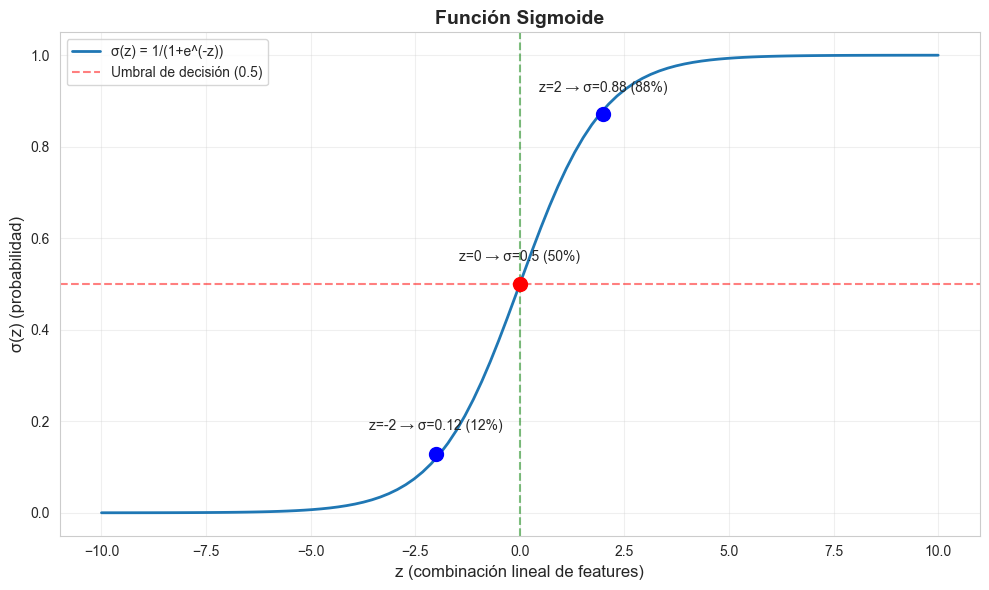

📊 INTERPRETACIÓN DE LA SIGMOIDE

💡 Características importantes:
   • Siempre da valores entre 0 y 1 (perfecto para probabilidades)
   • En z=0, σ=0.5 (50% de probabilidad)
   • z positivo grande → σ cercano a 1 (alta probabilidad de churn)
   • z negativo grande → σ cercano a 0 (baja probabilidad de churn)

   Si σ > 0.5 → Predicción: Churn (1)
   Si σ < 0.5 → Predicción: No Churn (0)


In [19]:
# Graficar la función sigmoide
z = np.linspace(-10, 10, 100)  # Valores de -10 a 10
sigmoid = 1 / (1 + np.exp(-z))  # Fórmula de la sigmoide

plt.figure(figsize=(10, 6))
plt.plot(z, sigmoid, linewidth=2, label='σ(z) = 1/(1+e^(-z))')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Umbral de decisión (0.5)')
plt.axvline(x=0, color='g', linestyle='--', alpha=0.5)
plt.xlabel('z (combinación lineal de features)', fontsize=12)
plt.ylabel('σ(z) (probabilidad)', fontsize=12)
plt.title('Función Sigmoide', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

# Marcar puntos importantes
plt.scatter([0], [0.5], color='red', s=100, zorder=5)
plt.text(0, 0.55, 'z=0 → σ=0.5 (50%)', fontsize=10, ha='center')
plt.scatter([2], [sigmoid[np.argmin(np.abs(z-2))]], color='blue', s=100, zorder=5)
plt.text(2, 0.92, 'z=2 → σ=0.88 (88%)', fontsize=10, ha='center')
plt.scatter([-2], [sigmoid[np.argmin(np.abs(z+2))]], color='blue', s=100, zorder=5)
plt.text(-2, 0.18, 'z=-2 → σ=0.12 (12%)', fontsize=10, ha='center')

plt.tight_layout()
plt.show()

print("📊 INTERPRETACIÓN DE LA SIGMOIDE")
print("=" * 60)
print("\n💡 Características importantes:")
print("   • Siempre da valores entre 0 y 1 (perfecto para probabilidades)")
print("   • En z=0, σ=0.5 (50% de probabilidad)")
print("   • z positivo grande → σ cercano a 1 (alta probabilidad de churn)")
print("   • z negativo grande → σ cercano a 0 (baja probabilidad de churn)")
print("\n   Si σ > 0.5 → Predicción: Churn (1)")
print("   Si σ < 0.5 → Predicción: No Churn (0)")

### 4.3 Análisis de Coeficientes

Los coeficientes nos dicen cuánto influye cada variable en la probabilidad de churn.

📊 COEFICIENTES DEL MODELO

Intercepto (β₀): -1.6459

Coeficientes de cada variable:
         Variable  Coeficiente
              Age     0.738847
   IsActiveMember    -0.515485
Geography_Germany     0.356679
           Gender    -0.260851
          Balance     0.160622
      CreditScore    -0.085986
    NumOfProducts    -0.070292
  EstimatedSalary     0.047725
        HasCrCard    -0.032208
           Tenure    -0.020071
  Geography_Spain     0.018907

💡 INTERPRETACIÓN:
   • Coeficiente POSITIVO → Aumenta la probabilidad de churn
   • Coeficiente NEGATIVO → Disminuye la probabilidad de churn
   • Mayor magnitud (en valor absoluto) → Mayor influencia


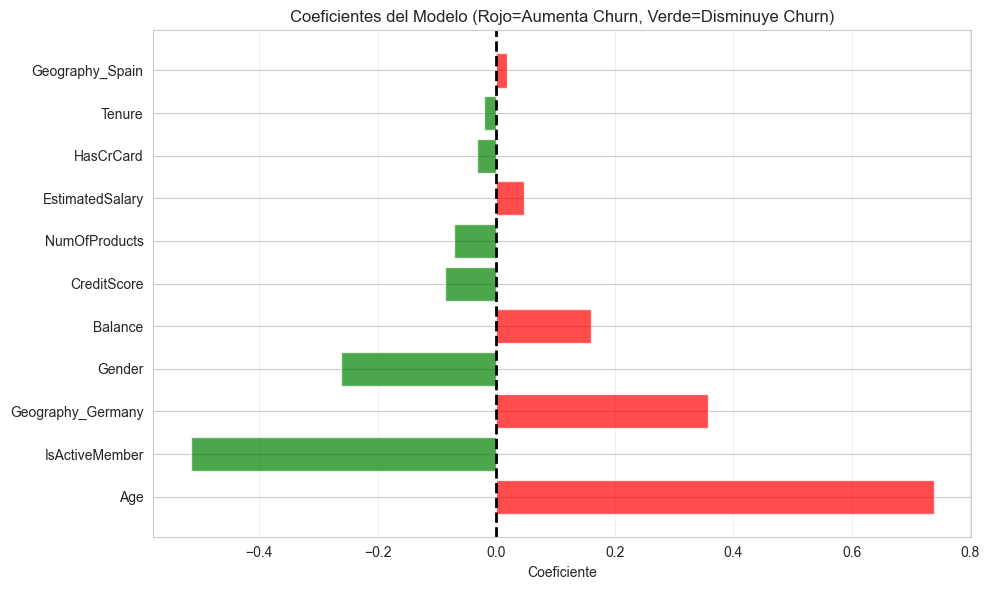

In [20]:
# Obtener coeficientes
coeficientes = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': modelo.coef_[0]
}).sort_values('Coeficiente', key=abs, ascending=False)

print("📊 COEFICIENTES DEL MODELO")
print("=" * 60)
print(f"\nIntercepto (β₀): {modelo.intercept_[0]:.4f}")
print("\nCoeficientes de cada variable:")
print(coeficientes.to_string(index=False))

print("\n💡 INTERPRETACIÓN:")
print("   • Coeficiente POSITIVO → Aumenta la probabilidad de churn")
print("   • Coeficiente NEGATIVO → Disminuye la probabilidad de churn")
print("   • Mayor magnitud (en valor absoluto) → Mayor influencia")

# Visualizar
plt.figure(figsize=(10, 6))
colors = ['red' if c > 0 else 'green' for c in coeficientes['Coeficiente']]
plt.barh(coeficientes['Variable'], coeficientes['Coeficiente'], color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
plt.xlabel('Coeficiente')
plt.title('Coeficientes del Modelo (Rojo=Aumenta Churn, Verde=Disminuye Churn)')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 4.4 Odds Ratios

Los Odds Ratios son más fáciles de interpretar que los coeficientes.

In [21]:
# Calcular Odds Ratios
odds_ratios = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': modelo.coef_[0],
    'Odds_Ratio': np.exp(modelo.coef_[0]),
    'Cambio_%': (np.exp(modelo.coef_[0]) - 1) * 100
}).sort_values('Odds_Ratio', ascending=False)

print("🎲 ODDS RATIOS")
print("=" * 80)
print(odds_ratios.to_string(index=False))

print("\n💡 CÓMO INTERPRETAR ODDS RATIOS:")
print("=" * 80)
print("\nOR > 1: Aumenta las odds de churn")
print("OR = 1: No tiene efecto")
print("OR < 1: Disminuye las odds de churn")

print("\n📝 EJEMPLOS PRÁCTICOS (Top 5):")
print("=" * 80)
for idx, row in odds_ratios.head(5).iterrows():
    var = row['Variable']
    or_val = row['Odds_Ratio']
    cambio = row['Cambio_%']
    
    if or_val > 1:
        print(f"\n✅ {var}:")
        print(f"   OR = {or_val:.3f}")
        print(f"   → Por cada unidad que aumenta {var},")
        print(f"     las odds de churn AUMENTAN un {cambio:.1f}%")
        if cambio > 100:
            print(f"     (¡Se más que DUPLICAN!)")
    else:
        print(f"\n✅ {var}:")
        print(f"   OR = {or_val:.3f}")
        print(f"   → Por cada unidad que aumenta {var},")
        print(f"     las odds de churn DISMINUYEN un {abs(cambio):.1f}%")

🎲 ODDS RATIOS
         Variable  Coeficiente  Odds_Ratio   Cambio_%
              Age     0.738847    2.093520 109.351968
Geography_Germany     0.356679    1.428578  42.857759
          Balance     0.160622    1.174241  17.424121
  EstimatedSalary     0.047725    1.048882   4.888247
  Geography_Spain     0.018907    1.019087   1.908700
           Tenure    -0.020071    0.980129  -1.987113
        HasCrCard    -0.032208    0.968306  -3.169444
    NumOfProducts    -0.070292    0.932122  -6.787808
      CreditScore    -0.085986    0.917607  -8.239334
           Gender    -0.260851    0.770396 -22.960431
   IsActiveMember    -0.515485    0.597211 -40.278916

💡 CÓMO INTERPRETAR ODDS RATIOS:

OR > 1: Aumenta las odds de churn
OR = 1: No tiene efecto
OR < 1: Disminuye las odds de churn

📝 EJEMPLOS PRÁCTICOS (Top 5):

✅ Age:
   OR = 2.094
   → Por cada unidad que aumenta Age,
     las odds de churn AUMENTAN un 109.4%
     (¡Se más que DUPLICAN!)

✅ Geography_Germany:
   OR = 1.429
   → Por cad

### 4.5 Intervalos de Confianza

Los intervalos de confianza nos dicen qué tan "seguros" estamos de los coeficientes.

In [22]:
# Calcular intervalos de confianza
# IMPORTANTE: Convertir DataFrame a numpy array para operaciones matriciales
X_train_array = X_train_scaled.values if isinstance(X_train_scaled, pd.DataFrame) else X_train_scaled

y_pred_proba_train = modelo.predict_proba(X_train_array)[:, 1]

# Matriz diagonal con varianzas
W = np.diag(y_pred_proba_train * (1 - y_pred_proba_train))

try:
    # Calcular matriz de varianza-covarianza
    var_covar_matrix = np.linalg.inv(X_train_array.T @ W @ X_train_array)
    std_errors = np.sqrt(np.diag(var_covar_matrix))
    
    # Intervalos de confianza al 95% (z = 1.96)
    z_value = 1.96
    coefs = modelo.coef_[0]
    lower_bounds = coefs - z_value * std_errors
    upper_bounds = coefs + z_value * std_errors
    
    # Crear DataFrame
    confidence_intervals = pd.DataFrame({
        'Variable': X_train.columns,
        'Coeficiente': coefs,
        'IC_Inferior': lower_bounds,
        'IC_Superior': upper_bounds,
        'Incluye_Cero': [(lower <= 0 <= upper) for lower, upper in zip(lower_bounds, upper_bounds)]
    })
    
    print("📊 INTERVALOS DE CONFIANZA AL 95%")
    print("=" * 80)
    print("\n¿Qué significa un intervalo de confianza del 95%?")
    print("   Si repitiéramos el experimento 100 veces, en 95 de ellas")
    print("   el verdadero coeficiente estaría dentro del intervalo.\n")
    print(confidence_intervals.to_string(index=False))
    
    print("\n💡 INTERPRETACIÓN:")
    print("=" * 80)
    print("\nVariables SIGNIFICATIVAS (el intervalo NO incluye cero):")
    significant = confidence_intervals[confidence_intervals['Incluye_Cero'] == False]
    for idx, row in significant.iterrows():
        direction = "AUMENTA" if row['Coeficiente'] > 0 else "DISMINUYE"
        print(f"   ✅ {row['Variable']}: {direction} churn (intervalo: [{row['IC_Inferior']:.3f}, {row['IC_Superior']:.3f}])")
    
    not_significant = confidence_intervals[confidence_intervals['Incluye_Cero'] == True]
    if len(not_significant) > 0:
        print("\nVariables NO significativas (el intervalo incluye cero):")
        for idx, row in not_significant.iterrows():
            print(f"   ⚠️ {row['Variable']}: Efecto no claro (intervalo: [{row['IC_Inferior']:.3f}, {row['IC_Superior']:.3f}])")
    
    print(f"\n✅ {len(significant)} de {len(confidence_intervals)} variables son estadísticamente significativas")
    
except:
    print("⚠️ No se pudieron calcular los intervalos de confianza")

📊 INTERVALOS DE CONFIANZA AL 95%

¿Qué significa un intervalo de confianza del 95%?
   Si repitiéramos el experimento 100 veces, en 95 de ellas
   el verdadero coeficiente estaría dentro del intervalo.

         Variable  Coeficiente  IC_Inferior  IC_Superior  Incluye_Cero
      CreditScore    -0.085986    -0.145149    -0.026824         False
           Gender    -0.260851    -0.319613    -0.202089         False
              Age     0.738847     0.683855     0.793839         False
           Tenure    -0.020071    -0.079180     0.039038          True
          Balance     0.160622     0.090492     0.230752         False
    NumOfProducts    -0.070292    -0.130566    -0.010017         False
        HasCrCard    -0.032208    -0.091184     0.026769          True
   IsActiveMember    -0.515485    -0.575518    -0.455452         False
  EstimatedSalary     0.047725    -0.011896     0.107347          True
Geography_Germany     0.356679     0.293118     0.420240         False
  Geography_Spai

## 5. Evaluación del Modelo

Ahora evaluamos qué tan bien predice el modelo.

### 5.1 Hacer Predicciones

In [23]:
# Hacer predicciones en el conjunto de test
y_pred = modelo.predict(X_test_scaled)                    # Predicciones (0 o 1)
y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1]  # Probabilidades (0 a 1)

print("🔮 PREDICCIONES")
print("=" * 60)
print("\nEjemplos (primeros 5 clientes del test):")
ejemplos = pd.DataFrame({
    'Real': y_test.values[:5],
    'Predicción': y_pred[:5],
    'Probabilidad_Churn': y_pred_proba[:5]
})
print(ejemplos.to_string(index=False))

print("\n💡 Interpretación:")
print("   • Real: Lo que realmente pasó (1=Se fue, 0=Se quedó)")
print("   • Predicción: Lo que el modelo predijo")
print("   • Probabilidad_Churn: Confianza del modelo (0-1)")
print("\n   Si probabilidad > 0.5 → Predicción = 1 (Churn)")
print("   Si probabilidad < 0.5 → Predicción = 0 (No Churn)")

🔮 PREDICCIONES

Ejemplos (primeros 5 clientes del test):
 Real  Predicción  Probabilidad_Churn
    0           0            0.118179
    0           0            0.279476
    0           0            0.112371
    0           0            0.146706
    0           0            0.095202

💡 Interpretación:
   • Real: Lo que realmente pasó (1=Se fue, 0=Se quedó)
   • Predicción: Lo que el modelo predijo
   • Probabilidad_Churn: Confianza del modelo (0-1)

   Si probabilidad > 0.5 → Predicción = 1 (Churn)
   Si probabilidad < 0.5 → Predicción = 0 (No Churn)


### 5.2 Matriz de Confusión

La matriz de confusión muestra los 4 tipos de resultados posibles:

```
                    Predicción
                No Churn  |  Churn
Real  No Churn     TN    |    FP
      Churn        FN    |    TP
```

**Tipos de resultados:**
- **TN** (se pronuncia "te ene", True Negative): Predijo "No Churn" y era correcto ✅
- **TP** (se pronuncia "te pe", True Positive): Predijo "Churn" y era correcto ✅
- **FP** (se pronuncia "efe pe", False Positive): Predijo "Churn" pero NO era (Falsa Alarma) ⚠️
- **FN** (se pronuncia "efe ene", False Negative): Predijo "No Churn" pero SÍ era (Cliente Perdido) ❌

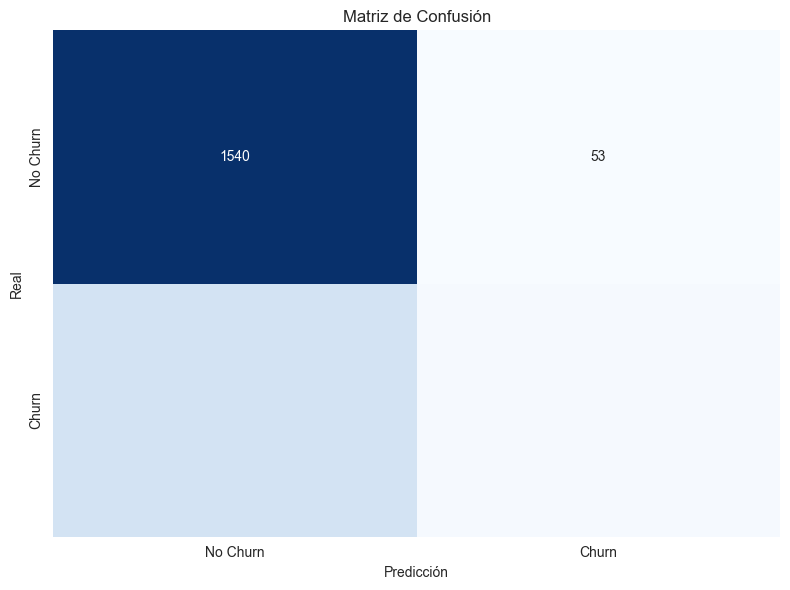


📊 DESGLOSE DE LA MATRIZ DE CONFUSIÓN

True Negatives (TN):  1540 ✅ Predijo 'No Churn' correcto
True Positives (TP):    76 ✅ Predijo 'Churn' correcto
False Positives (FP):   53 ⚠️  Falsa Alarma (predijo Churn pero no era)
False Negatives (FN):  331 ❌ Cliente Perdido (no detectó el churn)

💰 IMPACTO DE NEGOCIO:
   • FP (Falsa Alarma): Gastamos recursos innecesariamente en 53 clientes
   • FN (Cliente Perdido): Perdimos 331 clientes que no detectamos
   • En churn, FN es MÁS COSTOSO que FP


In [24]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

print("\n📊 DESGLOSE DE LA MATRIZ DE CONFUSIÓN")
print("=" * 60)
print(f"\nTrue Negatives (TN):  {tn:4d} ✅ Predijo 'No Churn' correcto")
print(f"True Positives (TP):  {tp:4d} ✅ Predijo 'Churn' correcto")
print(f"False Positives (FP): {fp:4d} ⚠️  Falsa Alarma (predijo Churn pero no era)")
print(f"False Negatives (FN): {fn:4d} ❌ Cliente Perdido (no detectó el churn)")

print("\n💰 IMPACTO DE NEGOCIO:")
print(f"   • FP (Falsa Alarma): Gastamos recursos innecesariamente en {fp} clientes")
print(f"   • FN (Cliente Perdido): Perdimos {fn} clientes que no detectamos")
print(f"   • En churn, FN es MÁS COSTOSO que FP")

### 5.3 Métricas: Precision, Recall, F1-Score

**Métricas principales:**

1. **Precision (Precisión)**: "De los que predije como Churn, ¿cuántos realmente eran?"
   $$Precision = \frac{TP}{TP + FP}$$

2. **Recall (Sensibilidad)**: "De los Churn reales, ¿cuántos detecté?"
   $$Recall = \frac{TP}{TP + FN}$$

3. **F1-Score**: "Balance entre Precision y Recall"
   $$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

**Analogía del detector de incendios:**
- **Precision**: Si la alarma suena, ¿realmente hay fuego?
- **Recall**: Si hay fuego, ¿la alarma suena?
- **F1**: Balance entre no tener falsas alarmas y no perder incendios reales

In [25]:
# Generar reporte completo
print("📊 REPORTE DE CLASIFICACIÓN")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Extraer métricas específicas
report_dict = classification_report(y_test, y_pred, output_dict=True)
# ⚠️ IMPORTANTE: Sin target_names en output_dict, las claves son '0' y '1' (no 'No Churn' y 'Churn')
precision_churn = report_dict['1']['precision']  # '1' = Churn
recall_churn = report_dict['1']['recall']
f1_churn = report_dict['1']['f1-score']

print("\n💡 INTERPRETACIÓN DE LAS MÉTRICAS (para Churn):")
print("=" * 60)
print(f"\nPrecision = {precision_churn:.2f} ({precision_churn*100:.1f}%)")
print(f"   → De los que predije como churn, {precision_churn*100:.1f}% realmente lo eran")
print(f"   → Ejemplo: Si predigo 100 churns, {int(precision_churn*100)} serán correctos")

print(f"\nRecall = {recall_churn:.2f} ({recall_churn*100:.1f}%)")
print(f"   → De los churns reales, detecté {recall_churn*100:.1f}%")
print(f"   → Ejemplo: Si hay 100 churns reales, detecto {int(recall_churn*100)}")

print(f"\nF1-Score = {f1_churn:.2f}")
print(f"   → Balance entre Precision y Recall")
print(f"   → Útil cuando necesitamos considerar ambas métricas")

# Análisis
print("\n🎯 ANÁLISIS:")
if recall_churn < 0.5:
    print(f"   ⚠️ RECALL BAJO: Solo detectamos {recall_churn*100:.0f}% de los churns")
    print("   → Estamos perdiendo muchos clientes")
elif recall_churn < 0.7:
    print(f"   ✅ RECALL MODERADO: Detectamos {recall_churn*100:.0f}% de los churns")
else:
    print(f"   ✅✅ RECALL ALTO: Detectamos {recall_churn*100:.0f}% de los churns")

📊 REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

    No Churn       0.82      0.97      0.89      1593
       Churn       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000


💡 INTERPRETACIÓN DE LAS MÉTRICAS (para Churn):

Precision = 0.59 (58.9%)
   → De los que predije como churn, 58.9% realmente lo eran
   → Ejemplo: Si predigo 100 churns, 58 serán correctos

Recall = 0.19 (18.7%)
   → De los churns reales, detecté 18.7%
   → Ejemplo: Si hay 100 churns reales, detecto 18

F1-Score = 0.28
   → Balance entre Precision y Recall
   → Útil cuando necesitamos considerar ambas métricas

🎯 ANÁLISIS:
   ⚠️ RECALL BAJO: Solo detectamos 19% de los churns
   → Estamos perdiendo muchos clientes


### 5.4 Curva ROC y AUC

**ROC (Receiver Operating Characteristic)**:
- Muestra el rendimiento del modelo a diferentes umbrales
- Eje X: False Positive Rate (qué % de No-Churn predecimos mal)
- Eje Y: True Positive Rate = Recall (qué % de Churn detectamos)

**AUC (Area Under the Curve)**:
- Área bajo la curva ROC
- Va de 0 a 1
- **Interpretación**:
  - AUC = 0.5: Modelo aleatorio (línea diagonal)
  - AUC = 0.7-0.8: Buen modelo
  - AUC > 0.8: Muy buen modelo
  - AUC = 1.0: Modelo perfecto

**Analogía**: Es como un examen donde AUC es tu nota final (de 0 a 1).

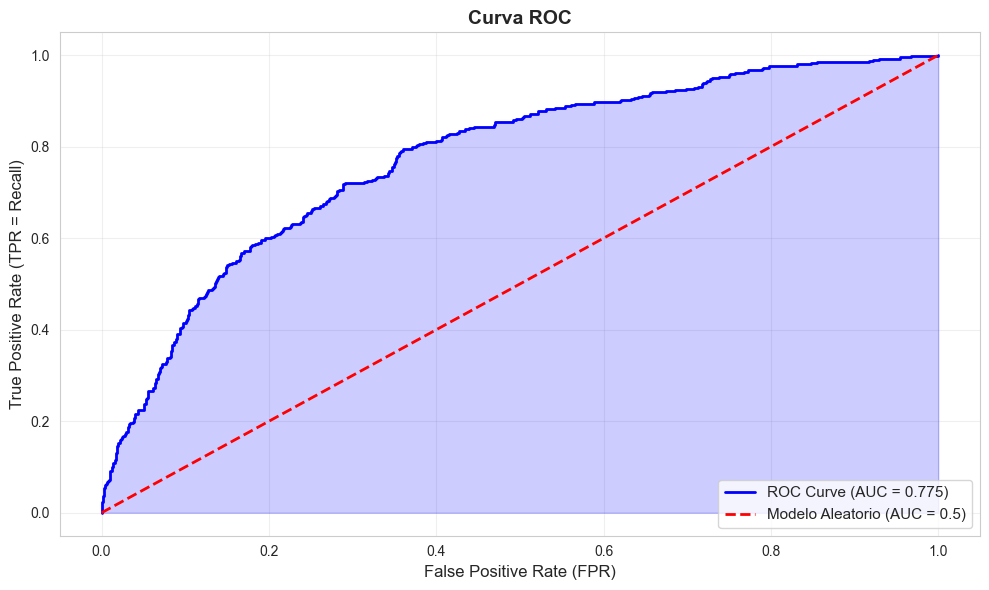

📊 CURVA ROC Y AUC

AUC Score: 0.7748

💡 INTERPRETACIÓN:
   ✅✅ Buen modelo (rendimiento sólido)

Significado práctico:
   Si tomo un cliente que se fue y uno que se quedó al azar,
   el modelo asignará mayor probabilidad de churn al correcto
   en 77.5% de las veces.


In [26]:
# Calcular ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Visualizar
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Modelo Aleatorio (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR = Recall)', fontsize=12)
plt.title('Curva ROC', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 CURVA ROC Y AUC")
print("=" * 60)
print(f"\nAUC Score: {auc_score:.4f}")

print("\n💡 INTERPRETACIÓN:")
if auc_score < 0.6:
    print("   ⚠️ Modelo pobre (apenas mejor que el azar)")
elif auc_score < 0.7:
    print("   ✅ Modelo aceptable (hay margen de mejora)")
elif auc_score < 0.8:
    print("   ✅✅ Buen modelo (rendimiento sólido)")
else:
    print("   ✅✅✅ Muy buen modelo (excelente rendimiento)")

print(f"\nSignificado práctico:")
print(f"   Si tomo un cliente que se fue y uno que se quedó al azar,")
print(f"   el modelo asignará mayor probabilidad de churn al correcto")
print(f"   en {auc_score*100:.1f}% de las veces.")

## 6. Conclusiones

Resumen de lo que logramos en este análisis.

In [27]:
print("="*80)
print("📋 RESUMEN DEL ANÁLISIS")
print("="*80)

print("\n🎯 PROBLEMA:")
print(f"   FinanceGuard tiene una tasa de churn del {churn_percentages[1]:.1f}%")
print(f"   ({churn_counts[1]:,} de {len(df):,} clientes se fueron)")

print("\n📊 MODELO BASELINE:")
print("   • Algoritmo: Regresión Logística")
print(f"   • Variables: {len(X.columns)} features")
print(f"   • Datos: {len(X_train):,} train, {len(X_test):,} test")

print("\n📈 RENDIMIENTO:")
print(f"   • AUC: {auc_score:.3f}")
print(f"   • Precision (Churn): {precision_churn:.3f}")
print(f"   • Recall (Churn): {recall_churn:.3f}")
print(f"   • F1-Score (Churn): {f1_churn:.3f}")

print("\n🔍 FACTORES MÁS INFLUYENTES:")
top_3 = odds_ratios.head(3)
for i, (idx, row) in enumerate(top_3.iterrows(), 1):
    direction = "AUMENTA" if row['Odds_Ratio'] > 1 else "DISMINUYE"
    print(f"   {i}. {row['Variable']}: OR={row['Odds_Ratio']:.2f} ({direction} churn)")

print("\n✅ LOGROS:")
print("   • Identificamos variables clave que influyen en el churn")
print("   • Creamos un modelo baseline para comparaciones futuras")
print("   • El modelo puede predecir probabilidades de churn")

print("\n🎯 PRÓXIMOS PASOS:")
print("   • Probar modelos más complejos (Gradient Boosting, Random Forest)")
print("   • Aplicar técnicas de balanceo de clases (SMOTE)")
print("   • Optimizar hiperparámetros")
print("   • Feature engineering (crear variables derivadas)")

print("\n" + "="*80)
print("✅ ANÁLISIS COMPLETADO")
print("="*80)

📋 RESUMEN DEL ANÁLISIS

🎯 PROBLEMA:
   FinanceGuard tiene una tasa de churn del 20.4%
   (2,037 de 10,000 clientes se fueron)

📊 MODELO BASELINE:
   • Algoritmo: Regresión Logística
   • Variables: 11 features
   • Datos: 8,000 train, 2,000 test

📈 RENDIMIENTO:
   • AUC: 0.775
   • Precision (Churn): 0.589
   • Recall (Churn): 0.187
   • F1-Score (Churn): 0.284

🔍 FACTORES MÁS INFLUYENTES:
   1. Age: OR=2.09 (AUMENTA churn)
   2. Geography_Germany: OR=1.43 (AUMENTA churn)
   3. Balance: OR=1.17 (AUMENTA churn)

✅ LOGROS:
   • Identificamos variables clave que influyen en el churn
   • Creamos un modelo baseline para comparaciones futuras
   • El modelo puede predecir probabilidades de churn

🎯 PRÓXIMOS PASOS:
   • Probar modelos más complejos (Gradient Boosting, Random Forest)
   • Aplicar técnicas de balanceo de clases (SMOTE)
   • Optimizar hiperparámetros
   • Feature engineering (crear variables derivadas)

✅ ANÁLISIS COMPLETADO


---

## 📚 Glosario de Términos

**Churn**: Cuando un cliente deja de usar el servicio

**Features (X)**: Variables independientes que usamos para predecir

**Target (y)**: Variable que queremos predecir (Exited)

**Sigmoide**: Función matemática que convierte números en probabilidades (0-1)

**Odds**: Relación entre probabilidad de que ocurra vs no ocurra

**Odds Ratio**: Cuánto cambian las odds cuando una variable aumenta

**Coeficiente**: Número que indica cuánto influye cada variable

**Precision**: % de predicciones positivas que son correctas

**Recall**: % de casos positivos reales que detectamos

**F1-Score**: Balance entre Precision y Recall

**AUC**: Área bajo la curva ROC (0-1, más alto = mejor)

**Train/Test**: División de datos para entrenar y evaluar

**Scaling**: Normalizar variables para que tengan escala similar

**Encoding**: Convertir categorías (texto) en números

---

**Desarrollado por:** Gobea Alcoba, Mariano 
**Curso:** Data Science - Henry  
**Módulo 4 - Clase 03:** Regresión Logística